In [1]:
!pip install pandas matplotlib seaborn missingno statsmodels prophet --upgrade
!pip install numpy==1.23.5 scipy==1.9.3 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 30.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 404.6 kB/s eta 0:0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

In [2]:
data = pd.read_csv('/content/seattle_weather_1948-2017.csv')

In [3]:
print("Dataset Info:")
data.info()

print("\nFirst 5 rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    25551 non-null  object 
 1   PRCP    25548 non-null  float64
 2   TMAX    25551 non-null  int64  
 3   TMIN    25551 non-null  int64  
 4   RAIN    25548 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB

First 5 rows:
         DATE  PRCP  TMAX  TMIN  RAIN
0  1948-01-01  0.47    51    42  True
1  1948-01-02  0.59    45    36  True
2  1948-01-03  0.42    45    35  True
3  1948-01-04  0.31    45    34  True
4  1948-01-05  0.17    45    32  True



Missing Values Overview:
DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64


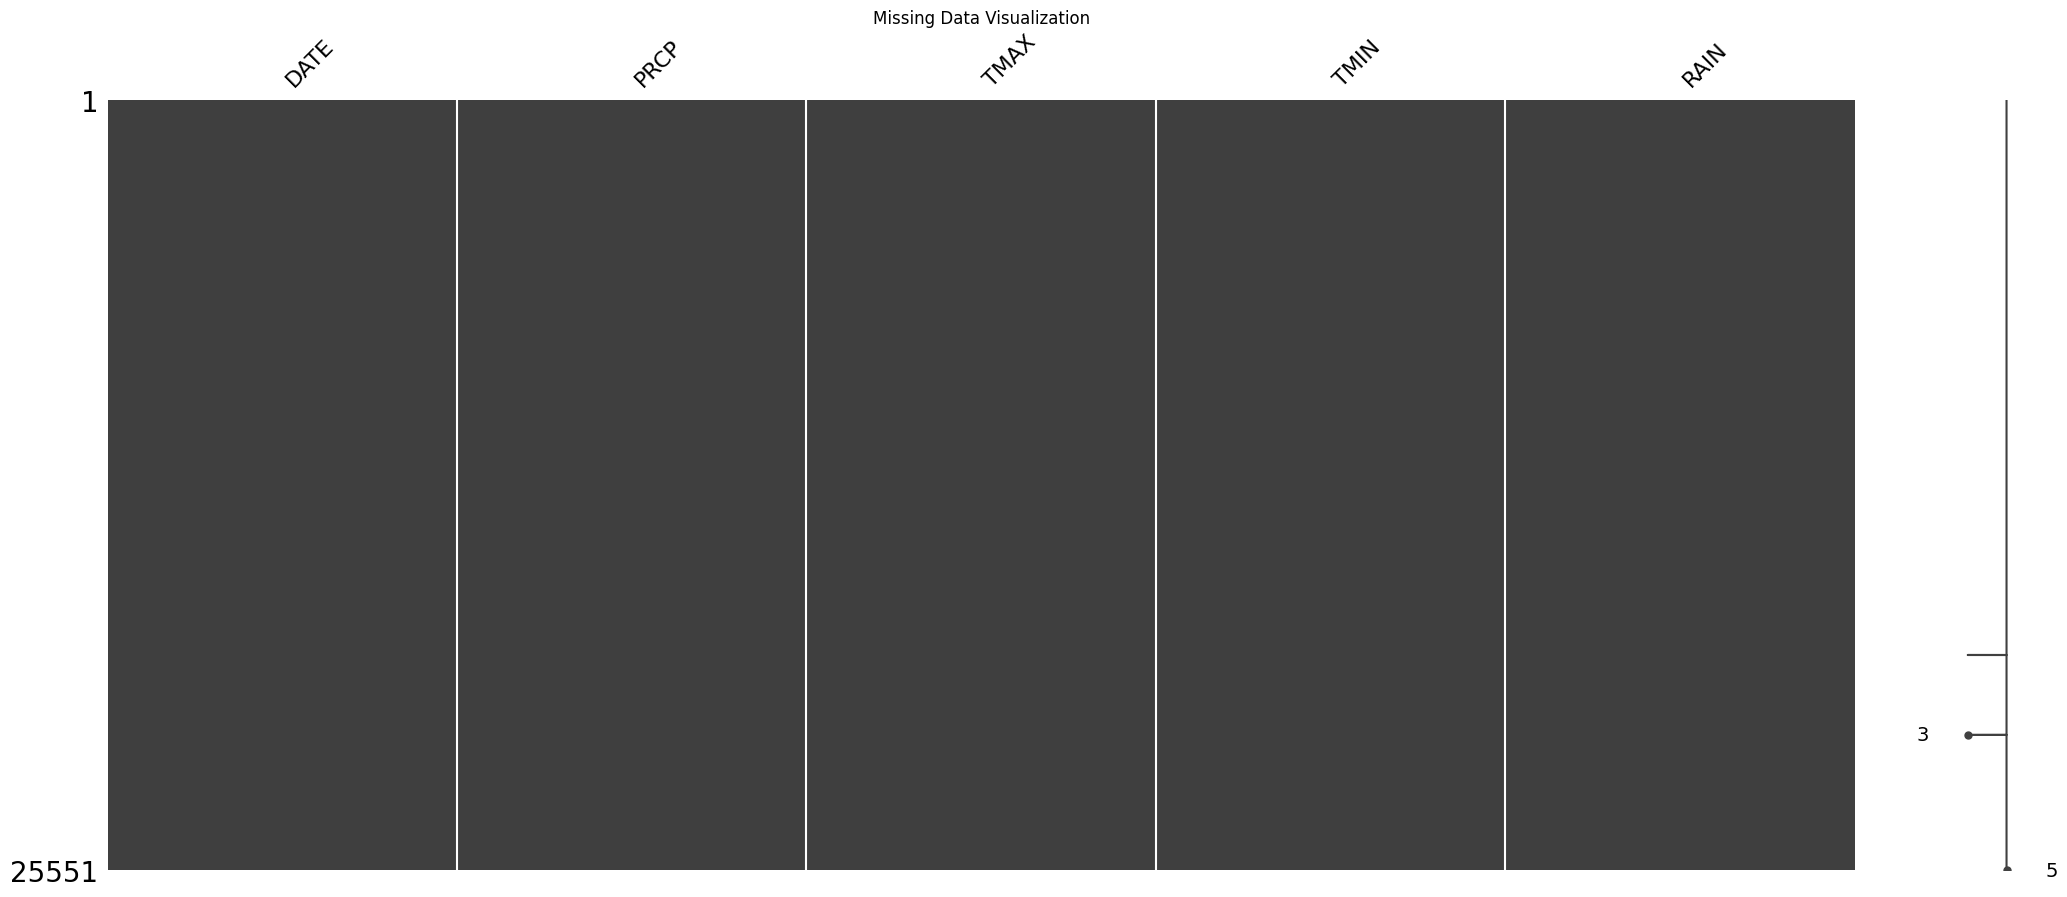

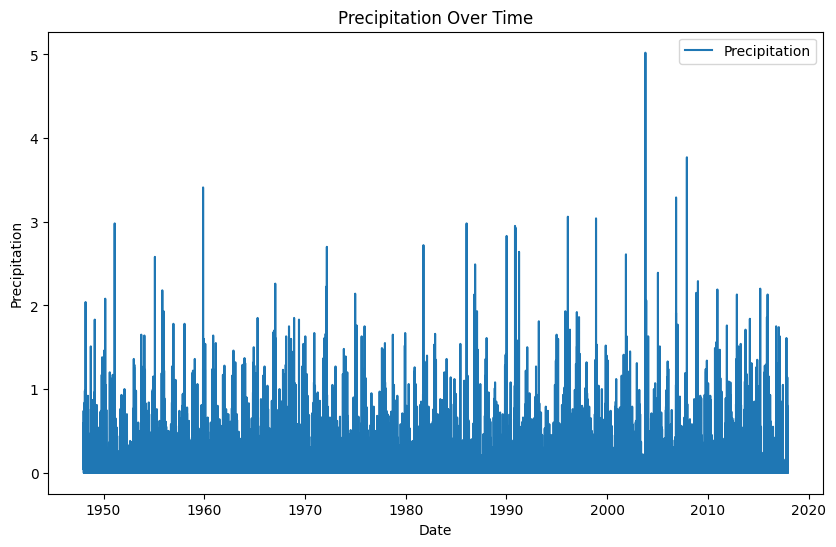


Performing Seasonal Decomposition...


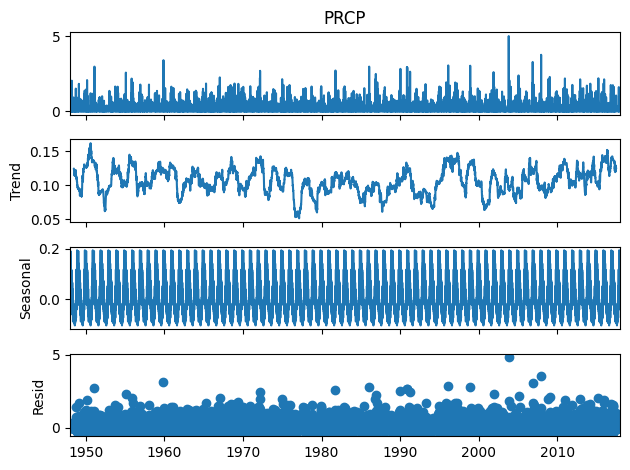


Generating Correlation Heatmap...


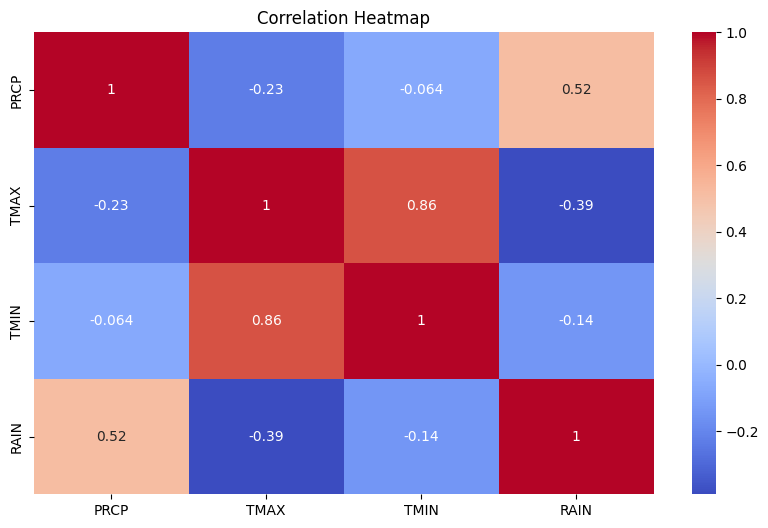

In [4]:
print("\nMissing Values Overview:")
print(data.isnull().sum())

# Visualize missing data
msno.matrix(data)
plt.title("Missing Data Visualization")
plt.show()

# Convert 'DATE' column to datetime and set it as index
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Visualize basic trends
plt.figure(figsize=(10, 6))
plt.plot(data['PRCP'], label='Precipitation')
plt.title("Precipitation Over Time")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()

# Seasonal decomposition (if PRCP is present)
if 'PRCP' in data.columns:
    print("\nPerforming Seasonal Decomposition...")
    decomposition = seasonal_decompose(data['PRCP'].fillna(0), model='additive', period=365)
    decomposition.plot()
    plt.show()

# Correlation heatmap
print("\nGenerating Correlation Heatmap...")
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [5]:
print("\nHandling Missing Values...")
data.fillna(method='ffill', inplace=True)

# Create a feature for temperature difference
if 'TMAX' in data.columns and 'TMIN' in data.columns:
    data['TEMP_DIFF'] = data['TMAX'] - data['TMIN']
    print("\nAdded 'TEMP_DIFF' feature (TMAX - TMIN).")

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numeric_features = ['PRCP', 'TMAX', 'TMIN', 'TEMP_DIFF']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

print("\nPreprocessed Data (First 5 rows):")
print(data.head())


Handling Missing Values...

Added 'TEMP_DIFF' feature (TMAX - TMIN).

Preprocessed Data (First 5 rows):
                PRCP      TMAX      TMIN  RAIN  TEMP_DIFF
DATE                                                     
1948-01-01  0.093625  0.474747  0.591549  True   0.571429
1948-01-02  0.117530  0.414141  0.507042  True   0.571429
1948-01-03  0.083665  0.414141  0.492958  True   0.584416
1948-01-04  0.061753  0.414141  0.478873  True   0.597403
1948-01-05  0.033865  0.414141  0.450704  True   0.623377


<ipython-input-5-befd0ca97e60>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-5-befd0ca97e60>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(method='ffill', inplace=True)



Applying KMeans Clustering...


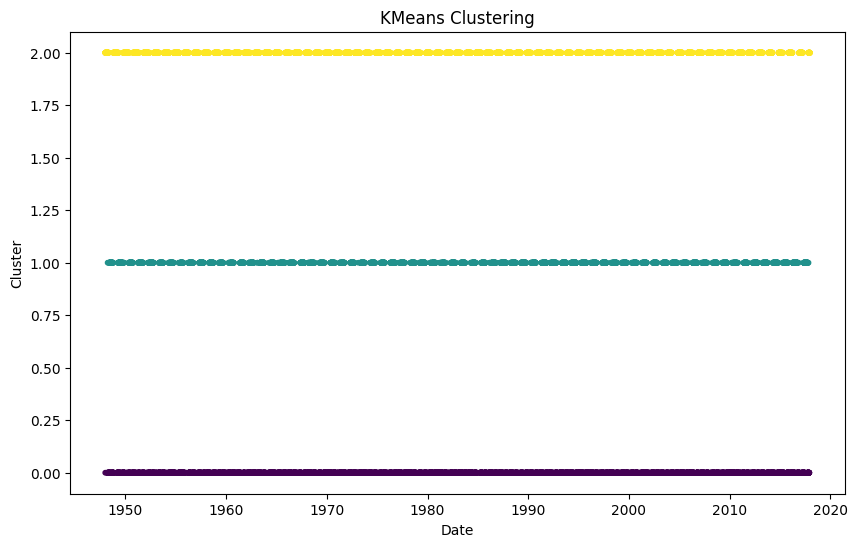


Applying Isolation Forest for Anomaly Detection...


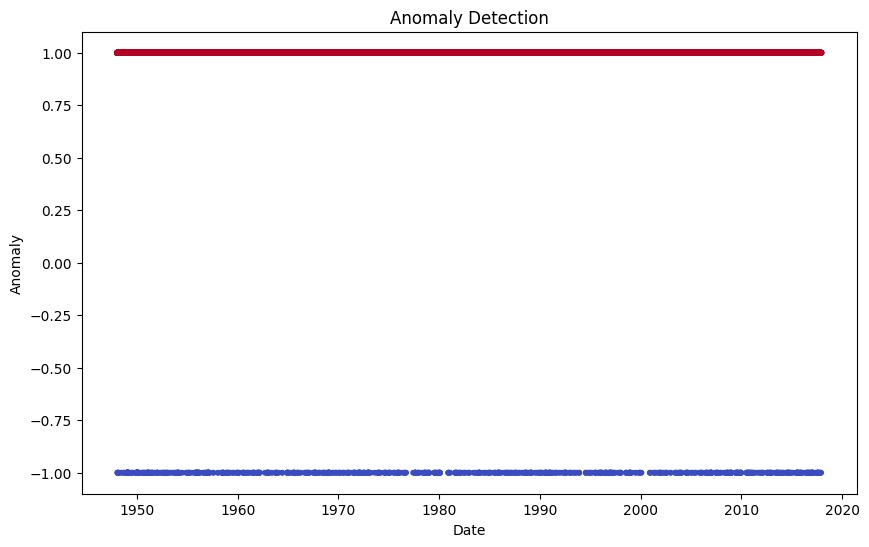

In [6]:
print("\nApplying KMeans Clustering...")
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[numeric_features])

# Visualize clustering
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data['Cluster'], c=data['Cluster'], cmap='viridis', s=10)
plt.title("KMeans Clustering")
plt.xlabel("Date")
plt.ylabel("Cluster")
plt.show()

# Apply Isolation Forest for anomaly detection
print("\nApplying Isolation Forest for Anomaly Detection...")
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['Anomaly'] = iso_forest.fit_predict(data[numeric_features])

# Visualize anomalies
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data['Anomaly'], c=data['Anomaly'], cmap='coolwarm', s=10)
plt.title("Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Anomaly")
plt.show()


Fitting ARIMA Model...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


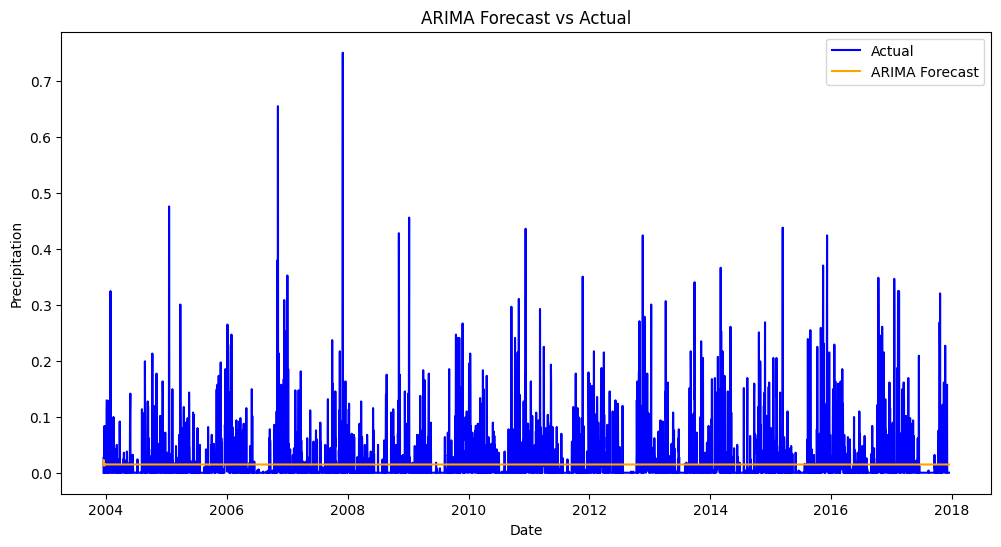

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgl5z7bda/0_yksaa0.json



Fitting Prophet Model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgl5z7bda/3xn32rhn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87316', 'data', 'file=/tmp/tmpgl5z7bda/0_yksaa0.json', 'init=/tmp/tmpgl5z7bda/3xn32rhn.json', 'output', 'file=/tmp/tmpgl5z7bda/prophet_model5bh2d74g/prophet_model-20241117071602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:16:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:16:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


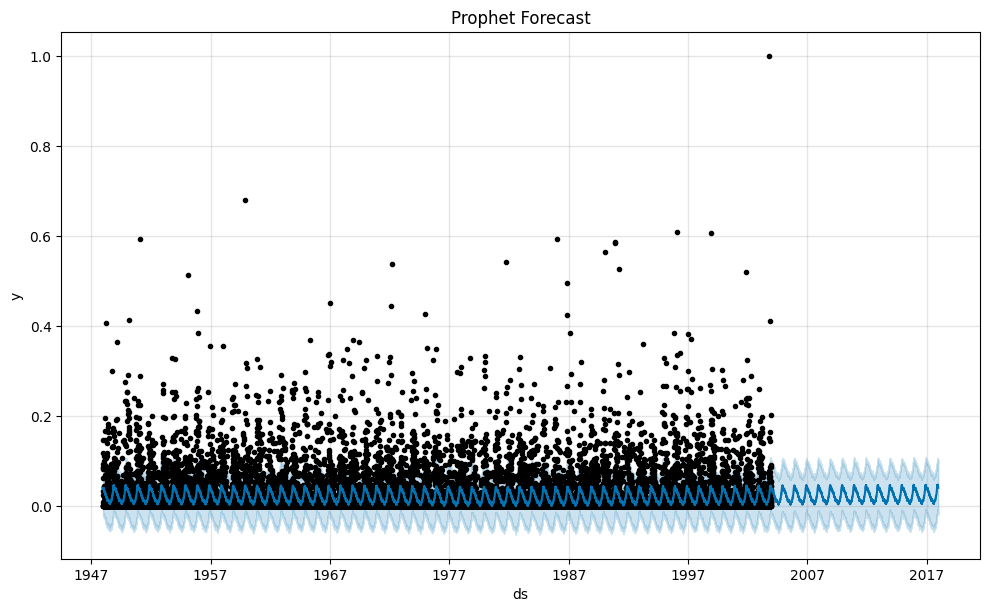

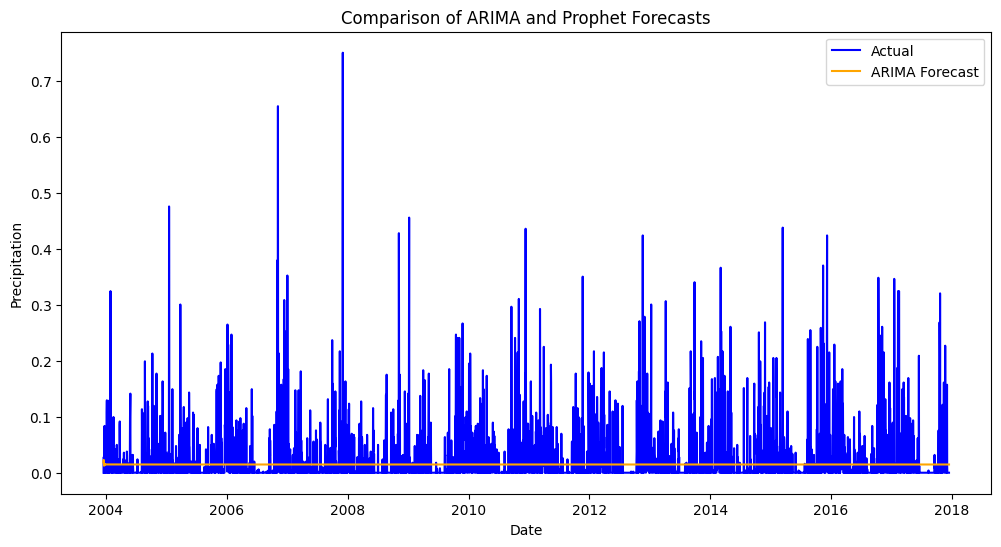

In [8]:
data_forecasting = data[['PRCP']].copy()

# Split into train and test sets
train_size = int(len(data_forecasting) * 0.8)
train_data, test_data = data_forecasting[:train_size], data_forecasting[train_size:]

# Forecast using ARIMA
print("\nFitting ARIMA Model...")
arima_model = ARIMA(train_data, order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast
arima_forecast = arima_result.forecast(steps=len(test_data))

# Plot ARIMA results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual", color="blue")
plt.plot(test_data.index, arima_forecast, label="ARIMA Forecast", color="orange")
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()

# Forecast using Prophet
print("\nFitting Prophet Model...")
prophet_data = data_forecasting.reset_index().rename(columns={'DATE': 'ds', 'PRCP': 'y'})
train_prophet, test_prophet = prophet_data[:train_size], prophet_data[train_size:]

prophet_model = Prophet()
prophet_model.fit(train_prophet)

future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast = prophet_model.predict(future)

# Plot Prophet results
prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

# Compare ARIMA and Prophet forecasts
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual", color="blue")
plt.plot(test_data.index, arima_forecast, label="ARIMA Forecast", color="orange")
plt.title("Comparison of ARIMA and Prophet Forecasts")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()